<a href="https://colab.research.google.com/github/RuslanFF1968/Pioneer/blob/main/Text_processing_using_RNN_%D0%B8_CNN%2C_medical_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files   # модуль для загрузки файлов в colab
import numpy as np               # библиотека для работы с массивами данных
import pandas as pd              # библиотека для обработки и анализа данных
import matplotlib.pyplot as plt  # библиотека для визуализации данных
import os                        # для работы с файловой системой
# для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils # модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential # последовательная модель нейросети кераса
# загружаем стандартные слои нейросети (полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence  # инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split                   # модуль для разбиения данных на обучающую и тестовую выборки

In [ ]:
def readText(fileName):          # объявляем функции для чтения файла, на вход отправляем путь к файлу
    f = open(fileName, 'r')        # задаем открытие нужного файла в режиме чтения
    text = f.read()                # читаем текст
    text = text.replace("\n", " ") # переносы строки переводим в пробелы

    return text                    # возвращаем текст файла

className = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит", "Холицестит", "Эзофагит", "Энтерит", "Язва"] # объявляем интересующие нас классы
nClasses = len(className)                                                         # считаем количество классов

In [ ]:
# загружаем обучающие тексты

Text = []

for i in className:              # проходим по каждому классу
    for j in os.listdir('/content/drive/My Drive/Базы/Болезни/'): # проходим по каждому файлу в папке с текстами
        if i in j:                   # проверяем, содержит ли файл j в названии имя класса i
            Text.append(readText('/content/drive/My Drive/Базы/Болезни/' + j)) # добавляем в обучающую выборку
            print(j, 'добавлен в обучающую выборку') # выводим информацию

Аппендицит.txt добавлен в обучающую выборку
Гастрит.txt добавлен в обучающую выборку
Гепатит.txt добавлен в обучающую выборку
Дуоденит.txt добавлен в обучающую выборку
Колит.txt добавлен в обучающую выборку
Панкреатит.txt добавлен в обучающую выборку
Холицестит.txt добавлен в обучающую выборку
Эзофагит.txt добавлен в обучающую выборку
Энтерит.txt добавлен в обучающую выборку
Язва.txt добавлен в обучающую выборку


In [ ]:
print(len(Text))    # количество элементов в trainText
print(len(Text[1])) # количество символов в первом источнике в trainText

10
6717


In [ ]:
#Получаем обучающую и тестовую выборки
def get_test_train(text):
    x_train=[]
    x_test =[]

    for i in range(len(text)):
        text_tr,text_test =train_test_split(text[i].split(),test_size=0.1, shuffle = False) # Делим текст на выборки
        x_train.append(' '.join(text_tr))
        x_test.append(' '.join(text_test))
    return x_train, x_test

x_train, x_test = get_test_train(Text)

In [ ]:
maxWordsCount = 15000 # определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(x_train)          # даём тексты в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # вытаскиваем индексы слов для просмотра

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(x_train) # обучающие тексты в индексы
testWordIndexes = tokenizer.texts_to_sequences(x_test)   # проверочные тексты в индексы

In [ ]:
# формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  # идём по всей длине вектора индексов
  # "откусываем" векторы длины xLen и смещаеммся вперёд на step

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  return xSample


# формирование обучающей и проверочной выборки
# из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # для каждого из 6 классов создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

  # формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range(nClasses):   # в диапазоне кол-ва классов (6)
    xT = classesXSamples[t]   # берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)):  # и каждое его окно
      xSamples.append(xT[i])  # добавляем в общий список выборки

    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)):  # на каждое окно выборки
      ySamples.append(currY)  # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# задаём базовые параметры
xLen = 50 # длина отрезка текста, по которой анализируем, в словах
step = 1  # шаг разбиения исходного текста на обучающие вектора

In [ ]:
# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding,
# но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(6876, 50)
(6876, 10)
(345, 50)
(345, 10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.1451 - loss: 2.8133 - val_accuracy: 0.1072 - val_loss: 2.3638
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6750 - loss: 1.0044 - val_accuracy: 0.1188 - val_loss: 2.3788
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9639 - loss: 0.1867 - val_accuracy: 0.2290 - val_loss: 2.2233
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9958 - loss: 0.0354 - val_accuracy: 0.4377 - val_loss: 2.1148
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0118 - val_accuracy: 0.4783 - val_loss: 2.3108
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.4870 - val_loss: 2.8728
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.4783 - val_loss: 3.3426
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 

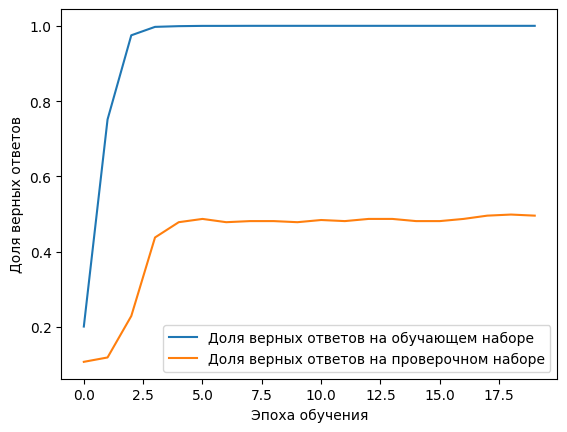

In [ ]:
modelED = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelED.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelED.add(Conv1D(200, 5, padding='same', activation='relu')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelED.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelED.add(Flatten())
modelED.add(BatchNormalization())  # добавляем слой нормализации данных
modelED.add(Dense(200, activation="relu"))  # добавляем полносвязный слой
modelED.add(Dropout(0.2))
modelED.add(BatchNormalization())
modelED.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelED.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelED.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()